# 3.2 线性回归的从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

2.5.1


## 3.2.1 生成数据集

In [19]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
print(features)
print(len(features))
# print(features[:,0])
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b   # t_w1 * 所有特征的第一列 + t_w2 * all_features_2 + b
print(f"更新前labels:{labels[:10]}")
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)
print(f"更新labels，{labels[:10]}")


tensor([[-2.4743,  0.4181],
        [-0.0789, -0.3581],
        [-0.6015,  1.2827],
        ...,
        [ 0.3180,  0.3992],
        [-0.6142, -0.4631],
        [ 1.1607,  0.6762]])
1000
更新前labels:tensor([-2.1703,  5.2599, -1.3643, -0.2440,  5.9145, 10.9511,  0.7255,  8.5453,
         2.1127,  4.6505])
更新labels，tensor([-2.1668,  5.2618, -1.3570, -0.2385,  5.9082, 10.9714,  0.7254,  8.5327,
         2.1107,  4.6575])


In [20]:
print(features[0], labels[0])

tensor([-2.4743,  0.4181]) tensor(-2.1668)


C:\Users\LEO323\AppData\Local\Temp\ipykernel_7152\3603935228.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


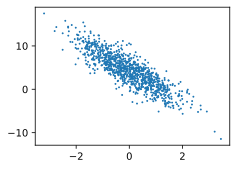

In [18]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    # display.set_matplotlib_formats
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [21]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [22]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2381,  1.4035],
        [ 0.5824,  0.0771],
        [-0.3737,  0.8621],
        [ 0.8526, -0.1339],
        [ 0.2948,  0.4152],
        [-0.4630,  0.2703],
        [ 1.7905, -0.9881],
        [-1.8203,  1.5005],
        [ 1.3443,  1.1256],
        [ 0.6491, -0.1786]]) 
 tensor([-0.1005,  5.0973,  0.5036,  6.3473,  3.3860,  2.3545, 11.1293, -4.5313,
         3.0421,  6.0918])


## 3.2.3 初始化模型参数

In [23]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
print(w)
b = torch.zeros(1, dtype=torch.float32)
print(b)

tensor([[ 0.0014],
        [-0.0063]])
tensor([0.])


In [24]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [26]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b  # 执行线性回归的前向计算，矩阵乘法和加法

## 3.2.5 定义损失函数

In [27]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [28]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.040611
epoch 2, loss 0.000144
epoch 3, loss 0.000050


In [30]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3992]], requires_grad=True)
4.2 
 tensor([4.1998], requires_grad=True)
